In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle

## Configuration

### Plotting styling

In [12]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstcsig4'] = 'black'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstcsig4'] = '--'

markers = {}
markers['Threshold0'] = 'o'
markers['Threshold'] = 'o'
markers['Mixedbcstcsig4'] = 'o'



legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstcsig4'] = 'Ideal BC+STC'

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstcsig4',
               ]

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [5]:
version = '220815'
fig_dir = '../img/electron_photon_calib_autoencoder_{}'.format(version)
algo_files = {}
# Read  first set
directory = '/data_CMS_upgrade/sauvan/HGCAL/2204_BCSTC-FE-studies/preprocessed-dataframes/3-29-1/oldfe/electrons_photons/v_1_2022-08-15'
fes = ['Threshold0', 'Threshold', 'Mixedbcstcsig4']

for fe in fes:
    algo_files[fe] = (glob(directory+'/electrons/*.hdf5'), glob(directory+'/photons/*.hdf5'))


## Loading and preprocessing dataframes

In [6]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [7]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [8]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [9]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

Threshold0
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 1.1619e+05, final cost 1.0867e+05, first-order optimality 1.03e-01.
[1.551111   0.94607043 1.0319325  1.0488455  1.0094072  1.079109
 1.0505931  1.0068007  0.957386   0.85157084 1.0167018  1.9690422
 2.        ]
Threshold
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 1.2354e+05, final cost 1.2037e+05, first-order optimality 6.02e-02.
[1.5665315 0.9981583 1.0567839 1.0619624 1.027516  1.0954901 1.0655411
 1.0275058 1.0034992 0.9026602 1.0292546 1.8132023 2.       ]
Mixedbcstcsig4
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.2434e+05, final cost 1.1517e+05, first-order optimality 4.51e-01.
[1.5953526 0.9606781 1.0484874 1.0550017 1.0264456 1.253205  1.0901228
 1.0664276 1.0602903 0.9377961 1.2019036 2.        2.       ]


Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [10]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

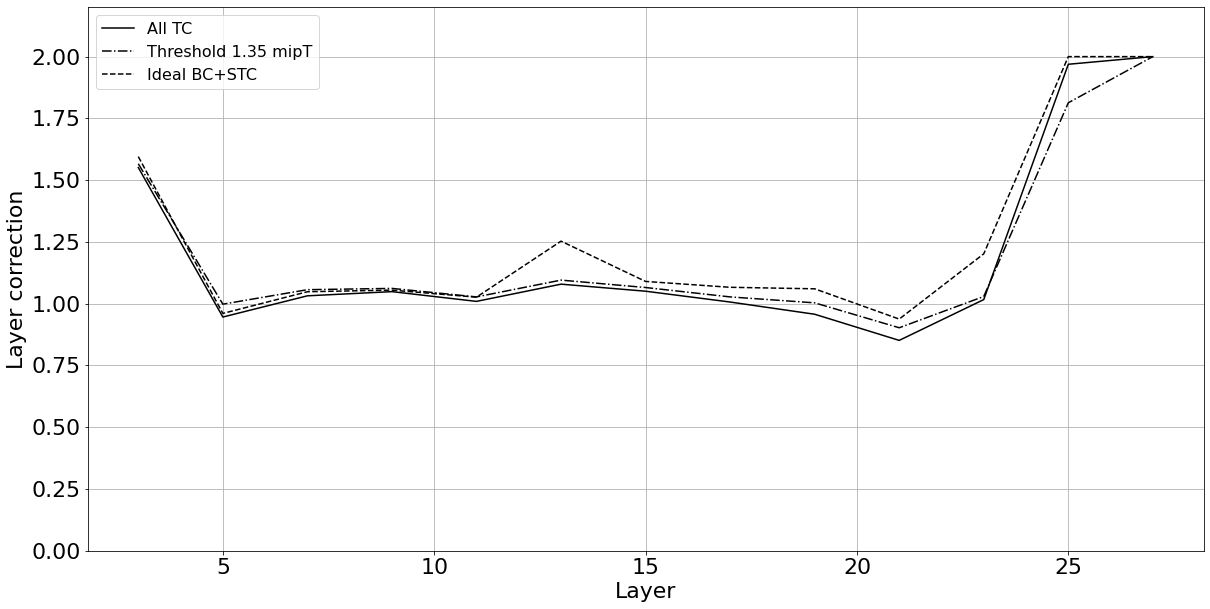

In [13]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.show()

Check impact of layer corrections on the energy ratio distributions

Raw mean=0.960657000541687, rms=0.036352258175611496, rms/mean=0.037841036915779114
Calib mean=0.9981547594070435, rms=0.04127463698387146, rms/mean=0.04135093837976456


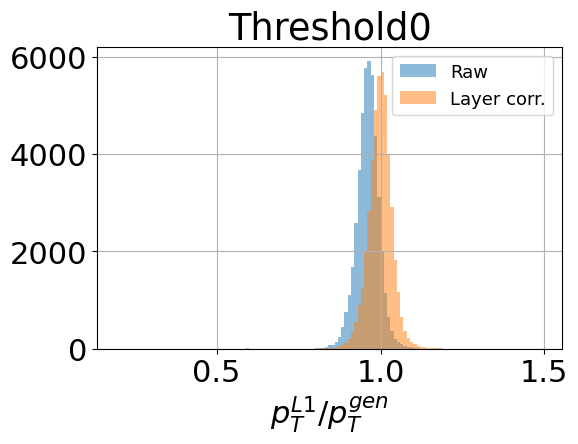

Raw mean=0.9300055503845215, rms=0.04231876879930496, rms/mean=0.045503780245780945
Calib mean=0.9851140379905701, rms=0.0469537079334259, rms/mean=0.04766321927309036


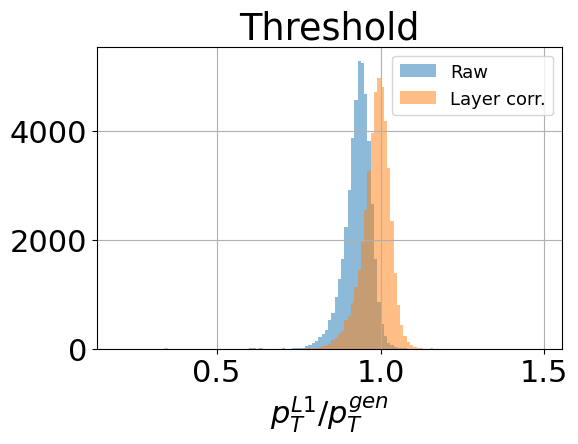

Raw mean=0.9156798124313354, rms=0.03668387606739998, rms/mean=0.04006190225481987
Calib mean=1.001612663269043, rms=0.04251797869801521, rms/mean=0.04244952276349068


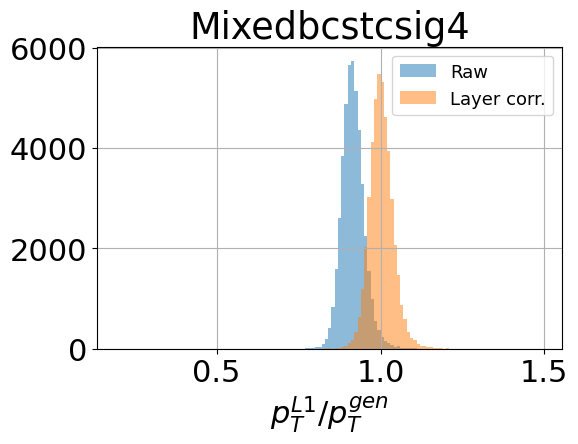

In [14]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [15]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  Threshold0
  Threshold
  Mixedbcstcsig4


Print correction value at eta=1.5 and eta=3

In [16]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

Threshold0
  eta=1.5: [5.056654]
  eta=3: [-8.894955]
Threshold
  eta=1.5: [4.8699636]
  eta=3: [-8.318663]
Mixedbcstcsig4
  eta=1.5: [4.803031]
  eta=3: [-3.4270067]


In [17]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt']    

Raw mean=1.0221834182739258, rms=0.1635771244764328, rms/mean=0.1600271761417389
Calib mean=1.0474833250045776, rms=0.1412431001663208, rms/mean=0.13484042882919312
Corr eta mean=1.00015127658844, rms=0.08512807637453079, rms/mean=0.08511520177125931


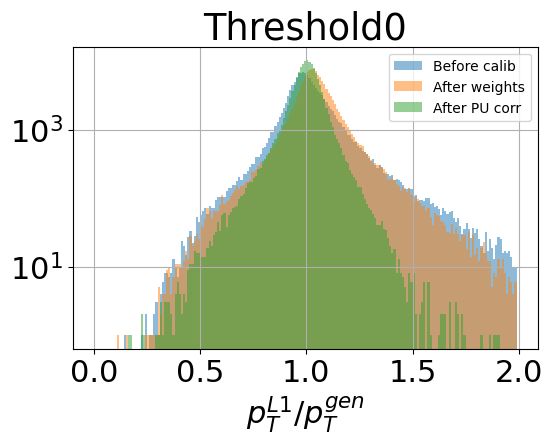

Raw mean=0.9754260778427124, rms=0.13365857303142548, rms/mean=0.1370258331298828
Calib mean=1.0352497100830078, rms=0.1311967968940735, rms/mean=0.12672960758209229
Corr eta mean=0.9927252531051636, rms=0.0883788913488388, rms/mean=0.089026540517807


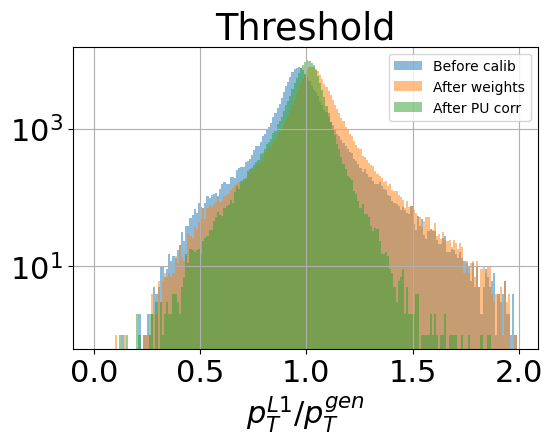

Raw mean=0.9295405745506287, rms=0.11793221533298492, rms/mean=0.1268715113401413
Calib mean=0.9855935573577881, rms=0.10182047635316849, rms/mean=0.1033087894320488
Corr eta mean=1.004144549369812, rms=0.0848298966884613, rms/mean=0.08447976410388947


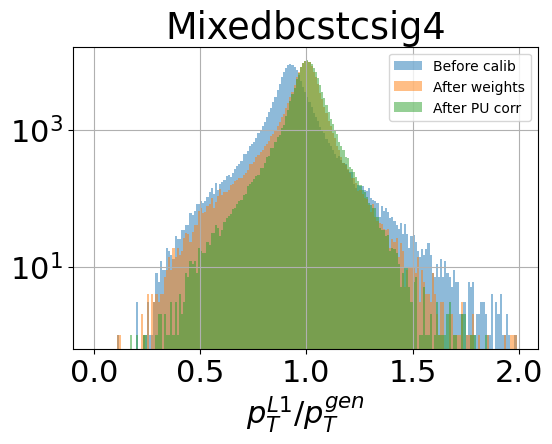

In [18]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.show()

## Final plots
For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [19]:
binetasize = 0.1
binptsize = 5
for name,df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = ((df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [20]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [21]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs eta


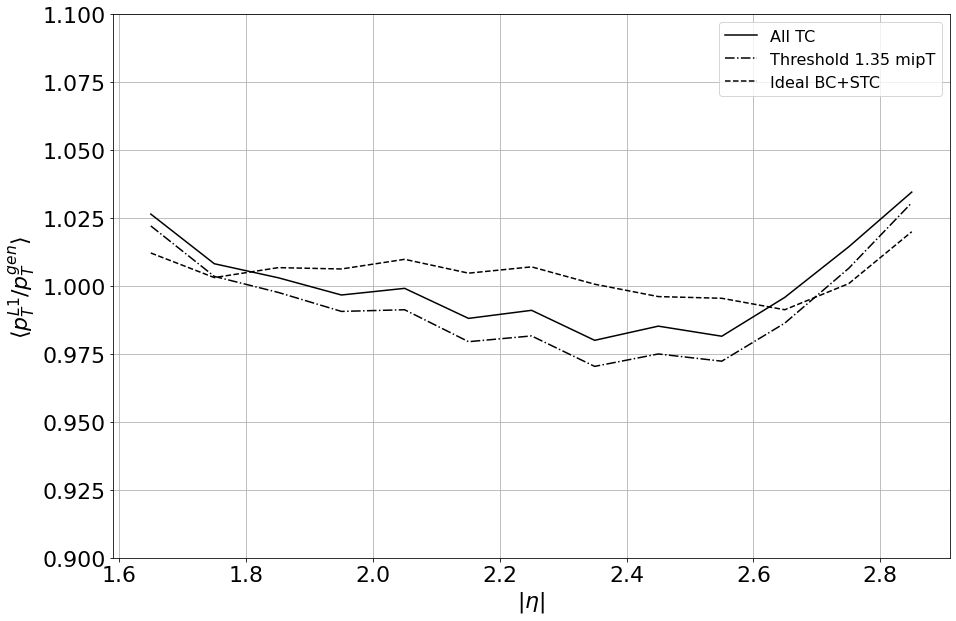

RMS vs eta


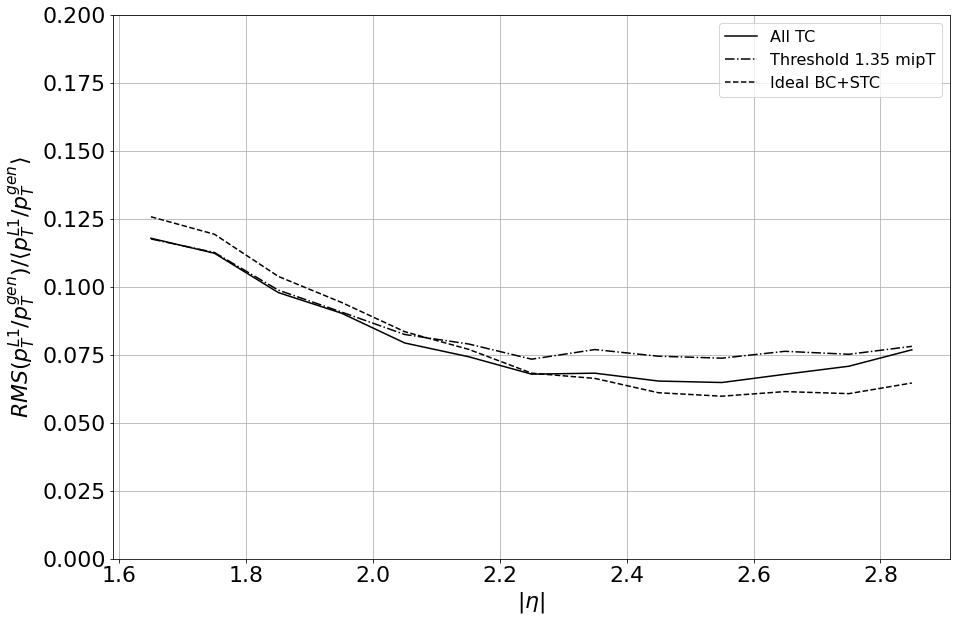

Eff RMS vs eta


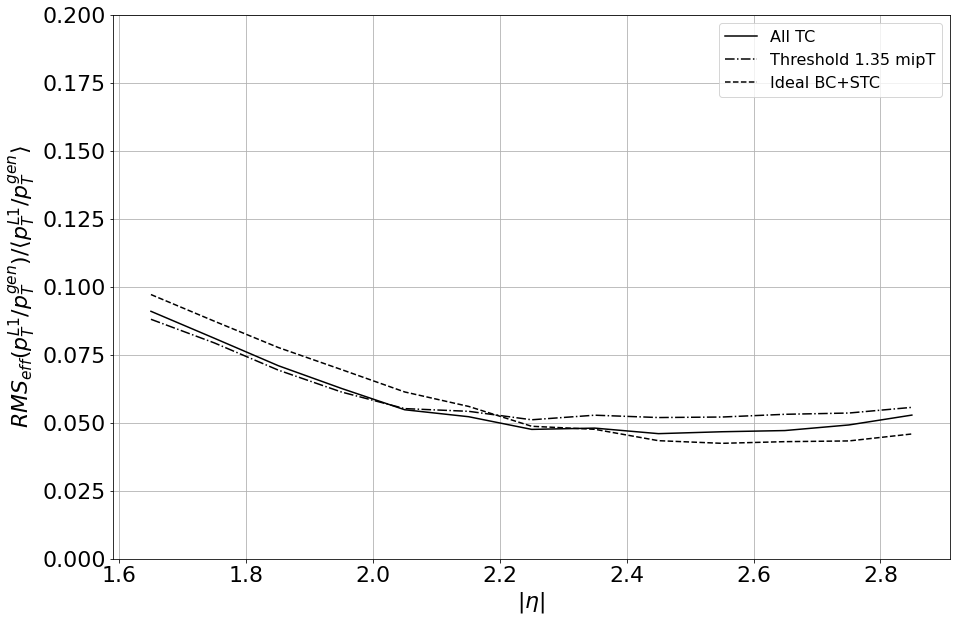

Mean vs pt


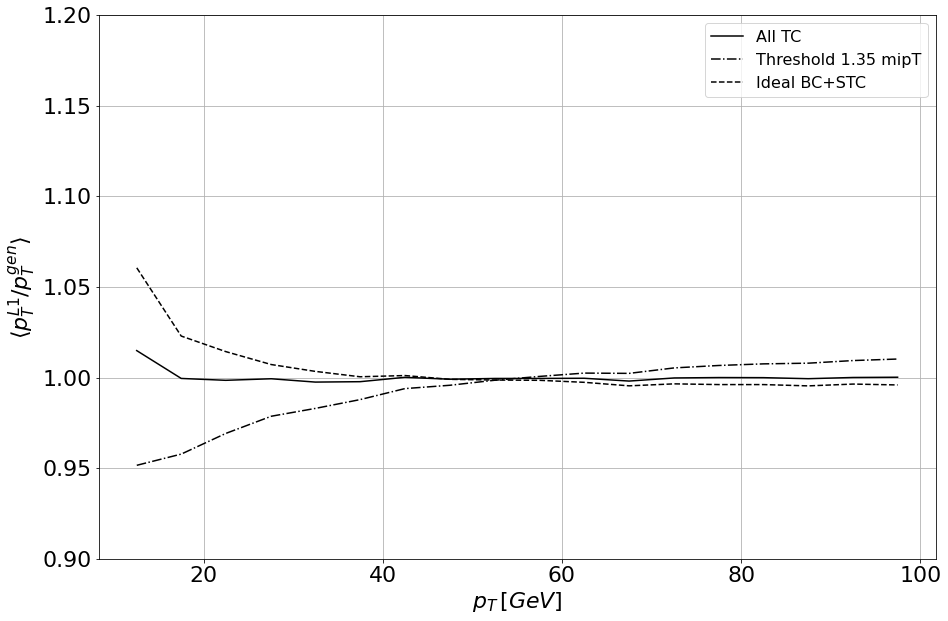

RMS vs pt


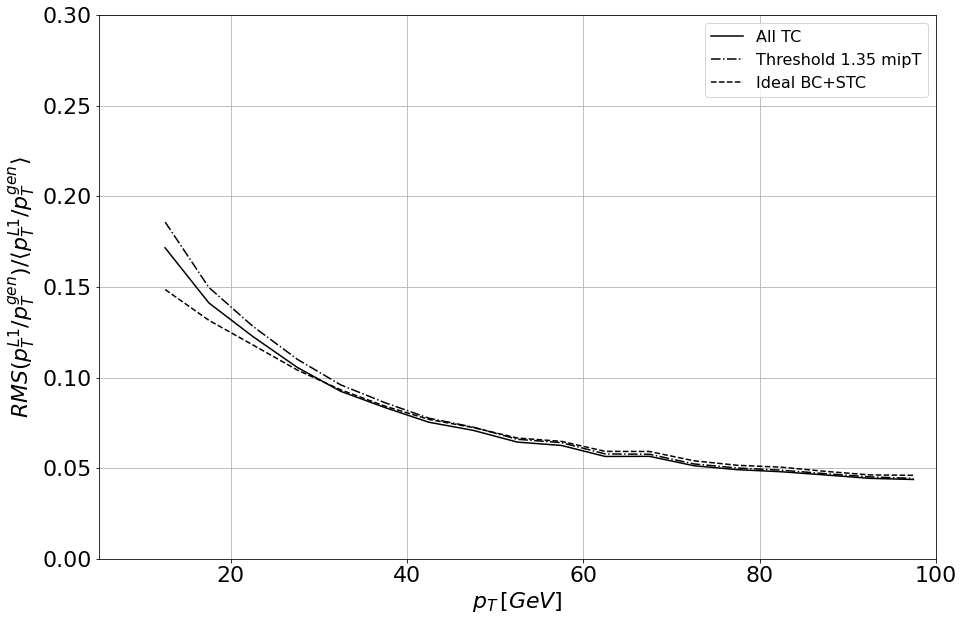

Eff RMS vs pt


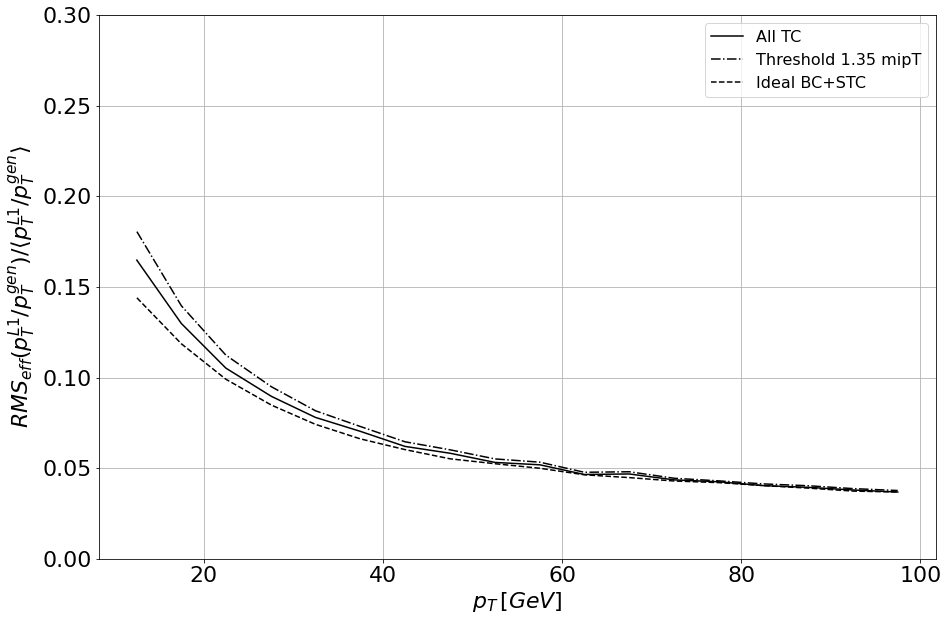

In [22]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

## Storing layer weights and eta corrections for external use

In [21]:
with open('../data/layer_weights_photons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(layer_coeffs, f)
with open('../data/lineareta_electrons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(corrs['eta'], f)